In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import zipfile
import os

In [ ]:
os.getcwd()

'/content'

In [ ]:
ls

COVID-19_Radiography_Dataset_3616.zip  sample_data/


In [ ]:
local_zip = 'COVID-19_Radiography_Dataset_3616.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('covid19_dataset/')
zip_ref.close()

In [ ]:
print(len(os.listdir('covid19_dataset/COVID/')))
print(len(os.listdir('covid19_dataset/Normal3616/')))

3616
3616


In [ ]:
img_src = '/content/covid19_dataset/COVID/COVID-1.png'
image = tf.io.read_file(img_src)
image = tf.image.decode_jpeg(image)

print(image.shape)
print(image)

image.shape
(299, 299, 1)
tf.Tensor(
[[[185]
  [ 40]
  [  0]
  ...
  [  0]
  [ 24]
  [131]]

 [[ 75]
  [ 14]
  [  0]
  ...
  [  0]
  [  8]
  [ 42]]

 [[ 11]
  [  2]
  [  0]
  ...
  [  1]
  [  3]
  [ 12]]

 ...

 [[ 78]
  [ 62]
  [ 68]
  ...
  [  3]
  [ 13]
  [ 27]]

 [[104]
  [ 74]
  [ 75]
  ...
  [  1]
  [ 23]
  [ 83]]

 [[156]
  [ 90]
  [ 78]
  ...
  [  1]
  [ 45]
  [167]]], shape=(299, 299, 1), dtype=uint8)


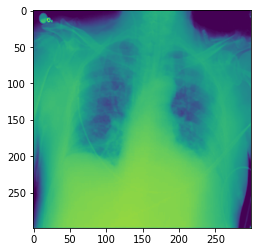

In [ ]:
from matplotlib.image import imread
img = imread(img_src)
plt.imshow(img)

In [ ]:
try:
    os.mkdir('covid19_split')
    os.mkdir('covid19_split/training')
    os.mkdir('covid19_split/testing')
    os.mkdir('covid19_split/training/covid19')
    os.mkdir('covid19_split/training/normal')
    os.mkdir('covid19_split/testing/covid19')
    os.mkdir('covid19_split/testing/normal')
except OSError:
    pass

In [ ]:
import random 
from shutil import copyfile 

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + "0이므로 무시")
  
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]
  
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
  
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


COVID19_SOURCE_DIR = "covid19_dataset/COVID/" 
TRAINING_COVID19_DIR = "covid19_split/training/covid19/"
TESTING_COVID19_DIR = "covid19_split/testing/covid19/"

NORMAL_SOURCE_DIR = "covid19_dataset/Normal3616/"
TRAINING_NORMAL_DIR = "covid19_split/training/normal/"
TESTING_NORMAL_DIR = "covid19_split/testing/normal/"

split_size = .9
split_data(COVID19_SOURCE_DIR, TRAINING_COVID19_DIR, TESTING_COVID19_DIR, split_size)
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)

In [ ]:
print(len(os.listdir('covid19_split/training/covid19')))
print(len(os.listdir('covid19_split/training/normal')))
print(len(os.listdir('covid19_split/testing/covid19')))
print(len(os.listdir('covid19_split/testing/normal')))

3254
3254
362
362


In [ ]:
TRAINING_DIR = "covid19_split/training"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(299, 299))

VALIDATION_DIR = "covid19_split/testing"
validation_datagen = ImageDataGenerator(
      rescale=1./255
      )

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (299, 299))

Found 6508 images belonging to 2 classes.
Found 724 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(299, 299, 1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2), 
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(), 
  
  tf.keras.layers.Dense(512, activation='relu'), 

  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fd120415290>>

In [ ]:
SPE_number = 150

checkpoint_path = "checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              save_weights_only=True,
                                              save_freq=SPE_number,
                                              verbose=1)

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=SPE_number,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=cp_callback)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7503
Epoch 00001: saving model to checkpoint/cp-0001.ckpt
150/150 [==============================] - 84s 561ms/step - loss: 0.5022 - accuracy: 0.7503 - val_loss: 0.6205 - val_accuracy: 0.7072
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.7704
Epoch 00002: saving model to checkpoint/cp-0002.ckpt
150/150 [==============================] - 86s 572ms/step - loss: 0.4813 - accuracy: 0.7704 - val_loss: 0.4826 - val_accuracy: 0.7486
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.7600
Epoch 00003: saving model to checkpoint/cp-0003.ckpt
150/150 [==============================] - 84s 557ms/step - loss: 0.4882 - accuracy: 0.7600 - val_loss: 0.4917 - val_accuracy: 0.7555
Epoch 4/10
150/150 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.7724
Epoch 00004: saving model to checkpoint/cp-0004.ckpt
15

Text(0.5, 1.0, 'Training and validation loss')

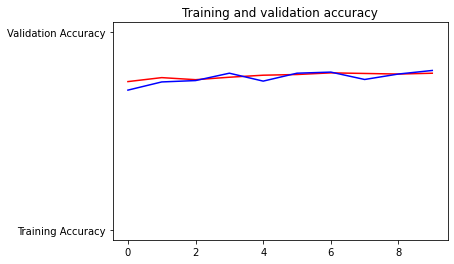

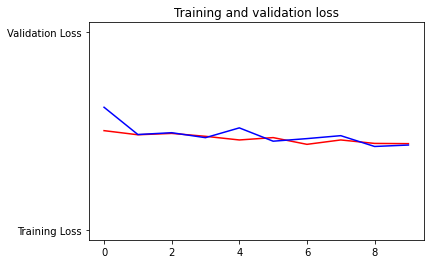

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()
  

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')